The target time series is the time series we are interested to forecast (given its history)

A covariate time series is a time series which may help in the forecasting of the target series, but that we are not interested in forecasting. It’s sometimes also called external data.

(https://unit8co.github.io/darts/examples/01-multi-time-series-and-covariates.html)

A time series with several dimensions is really just a regular time series where the values at each time stamps are vectors instead of scalars.

(stessa fonte di sopra)


Note that below, we are calling predict() with a horizon of 36, which is longer than the model internal output_chunk_length of 12. That’s not a problem here - as explained above, in such a case the internal model will simply be called auto-regressively on its own outputs. In this case, it will be called three times so that the three 12-points outputs make up the final 36-points forecast - but all of this is done transparently behind the scenes

(stessa fonte di sopra)

Note that here the covariates series are multivariate time series: they contain two dimensions - one dimension for the year and one for the month.

(stessa fonte di sopra)

Per quanto riguarda il funzionamento delle past e future covariates:
Note that here we called predict() with a forecast horizon n that is larger than the output_chunk_length we trained our model with. We were able to do this because even though BlockRNNModel uses past covariates, in this case these covariates are also known into the future, so Darts is able to compute the forecasts auto-regressively for n time steps in the future.

For the RNNModel, we can use a similar approach by just providing future_covariates to the predict() function

**Serie multivariate**

Now, instead of having to forecast only one variable, we would like to forecast several of them at once. In constrast of the multi-series training, where two different univariate datasets were used to train a single model, the training set consists in a single serie containing observations for several variables (called components). These components usually present the same nature (measurement of the same metric) but this is not necessarily the case.

Since this multivariate serie is particularly large (370 components, 140’256 values), we keep only 3 components

Due to the parameters selection, favoring speed over accuracy, the quality of the forecast is not great. Using more components from the original dataset or increasing the size of the training set should improve the accuracy of both models. Another possible improvement would be to account for the daily seasonality of the dataset by setting p (time lag) to 24 instead of 12 in the VARIMA model, and to retrain it.

(stessa sopra)

Multivariate data is often more
difficult to work with. It is harder to model and often many of the classical methods do not
perform well.
(libro: predizione serie storiche con python pg 29)

Multiple series training (global models): All machine learning based models (incl. all neural networks) support being trained on multiple (potentially multivariate) series. This can scale to large datasets too.

**Backtesting**: Utilities for simulating historical forecasts, using moving time windows.

(https://unit8co.github.io/darts/index.html)

Backtesting: Nel caso studio è stata usata: 'expanding window technique'.
This has the benefit again of providing a much more robust estimation of how the chosen modeling method and parameters will perform in practice. This improved estimate comes at the computational cost of creating so many models
Walk-forward validation is the gold standard of model evaluation. It is the k-fold cross validation of the time series world and is recommended for your own projects.

(https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)

**Modelli che supportano serie multivariate:**

Naive Baselines,

VARIMA,

RegressionModel,

RandomForest,

LinearRegressionModel,

LightGBMModel,

RNNModel,

**Imports**

In [1]:
import os

In [2]:
%reload_ext autoreload
%autoreload 2

from package import functions

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import average
from numpy import corrcoef
from numpy import arange
from sklearn.metrics import mean_absolute_percentage_error

import re

from pmdarima.arima import auto_arima

from darts import TimeSeries

In [3]:
top_series = pd.read_csv('./data/top_series_train.csv', index_col='date', parse_dates=True)

In [4]:
date_index = pd.date_range(start='01/01/2013', end='15/08/2017', freq='D')
df = top_series.reindex(date_index)

In [5]:
top_series = top_series.reindex(date_index, method='bfill')

In [6]:
top_series= top_series.replace(to_replace=0, method='bfill')

In [7]:
dict_diff_series = {}

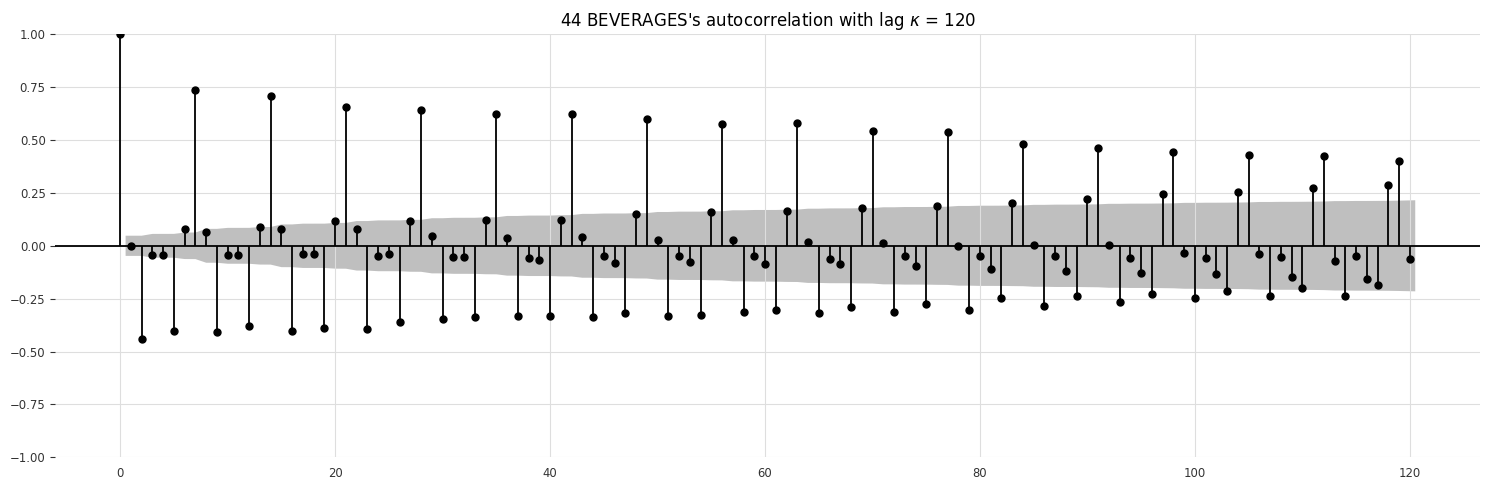

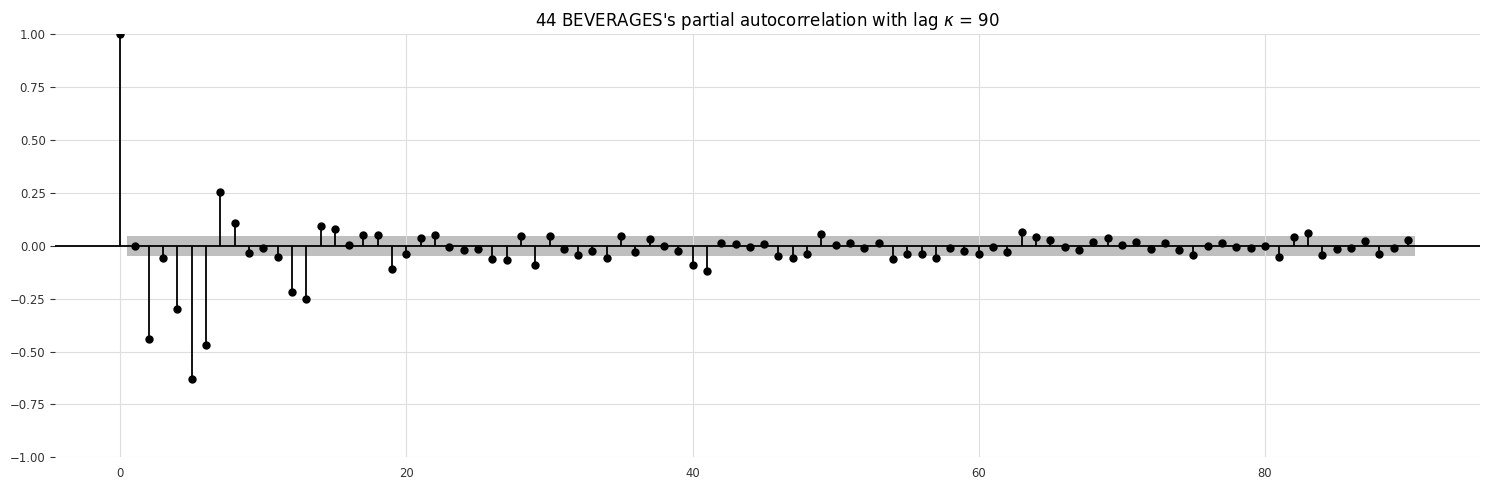

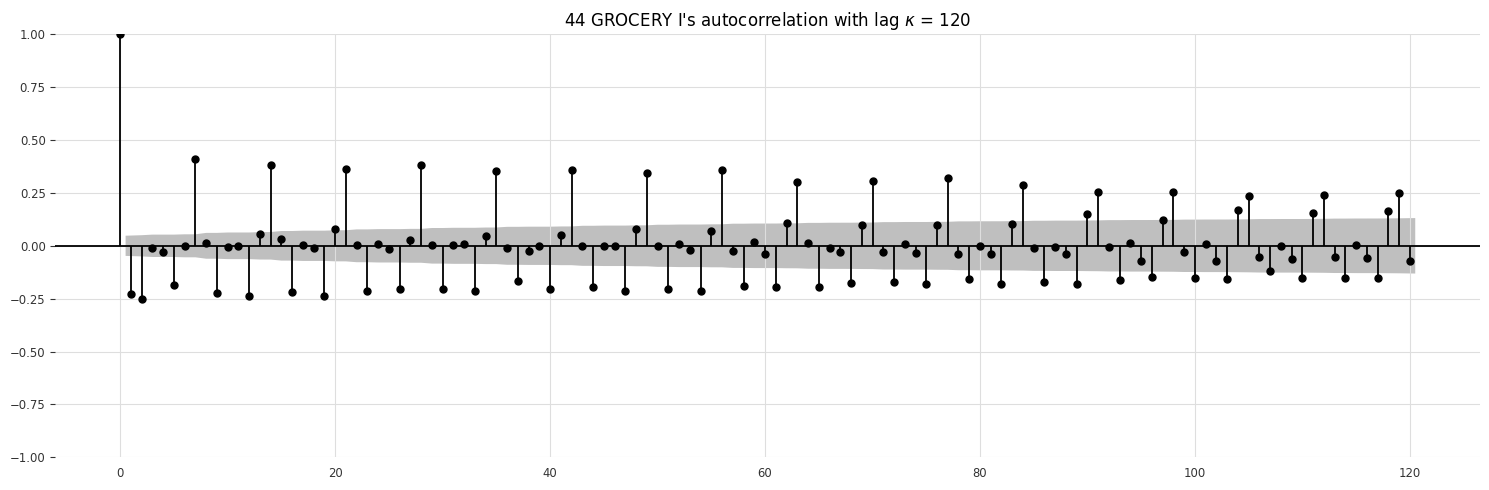

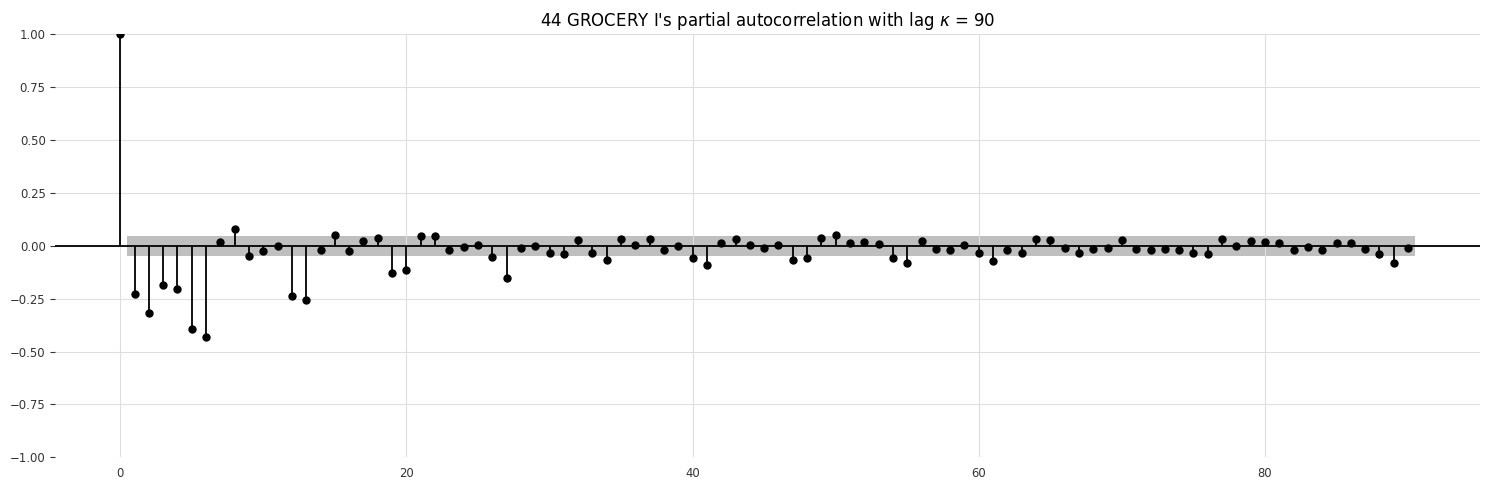

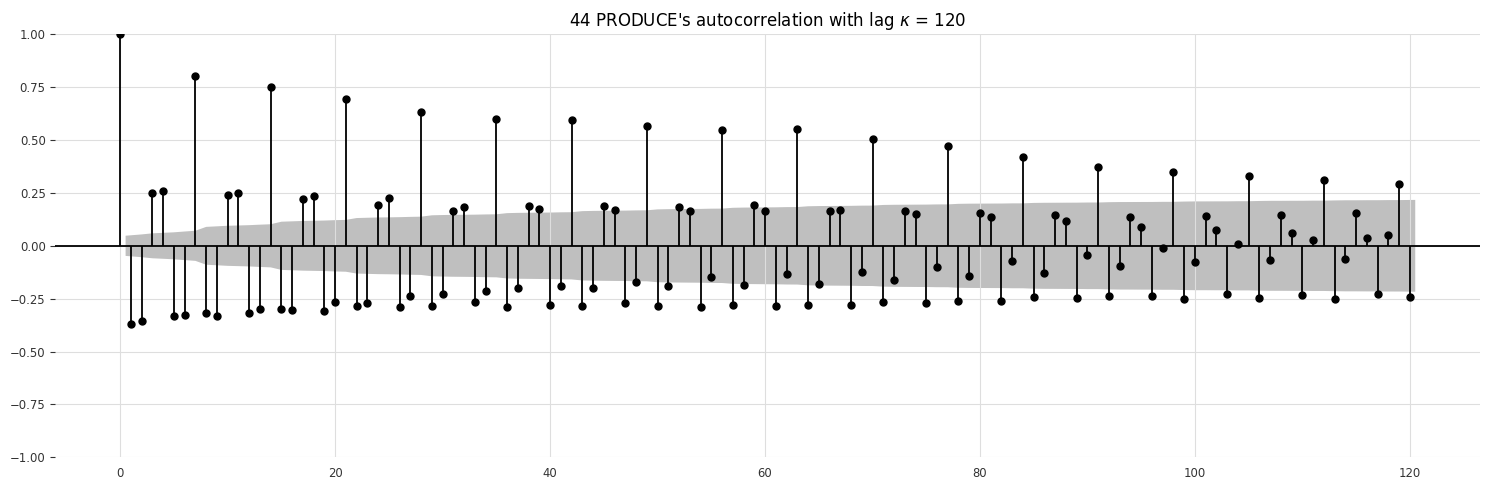

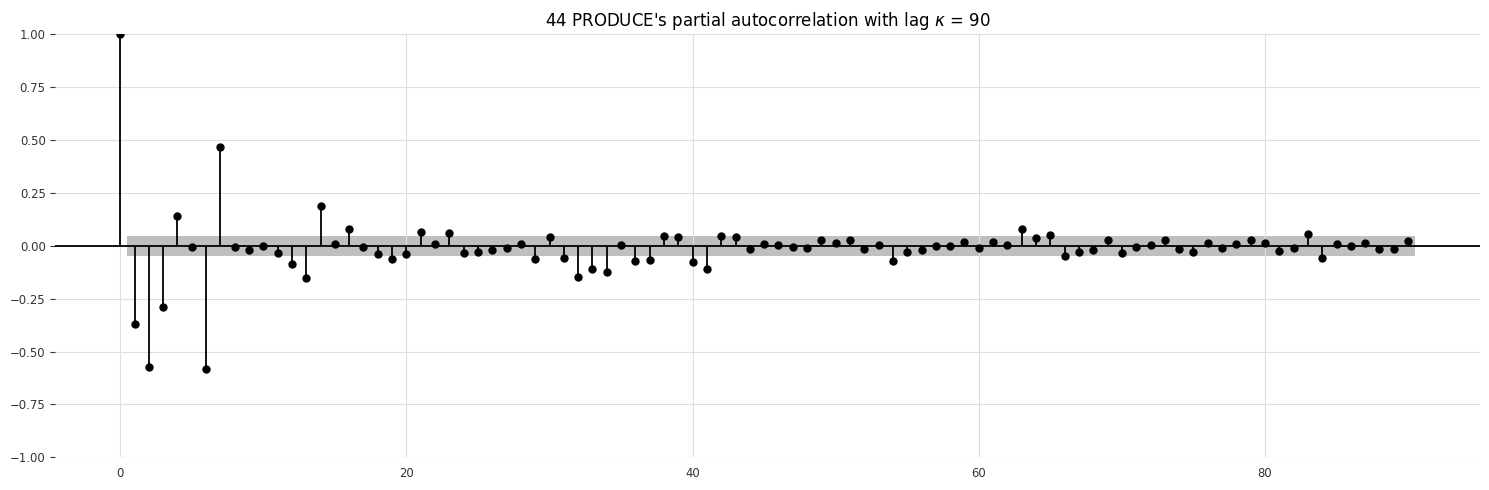

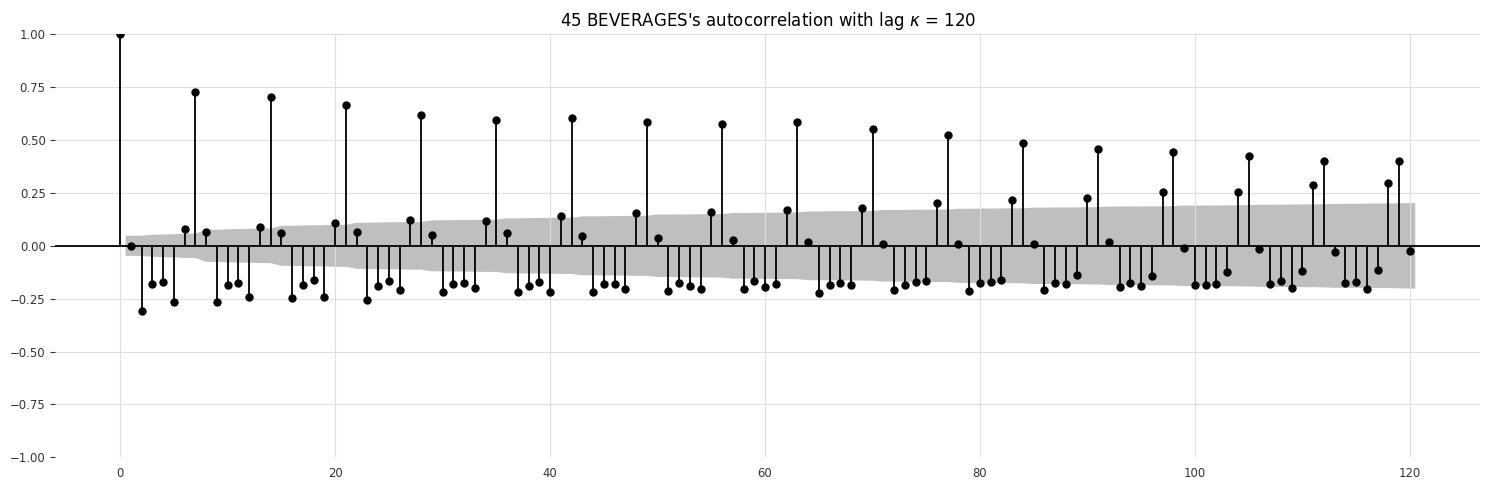

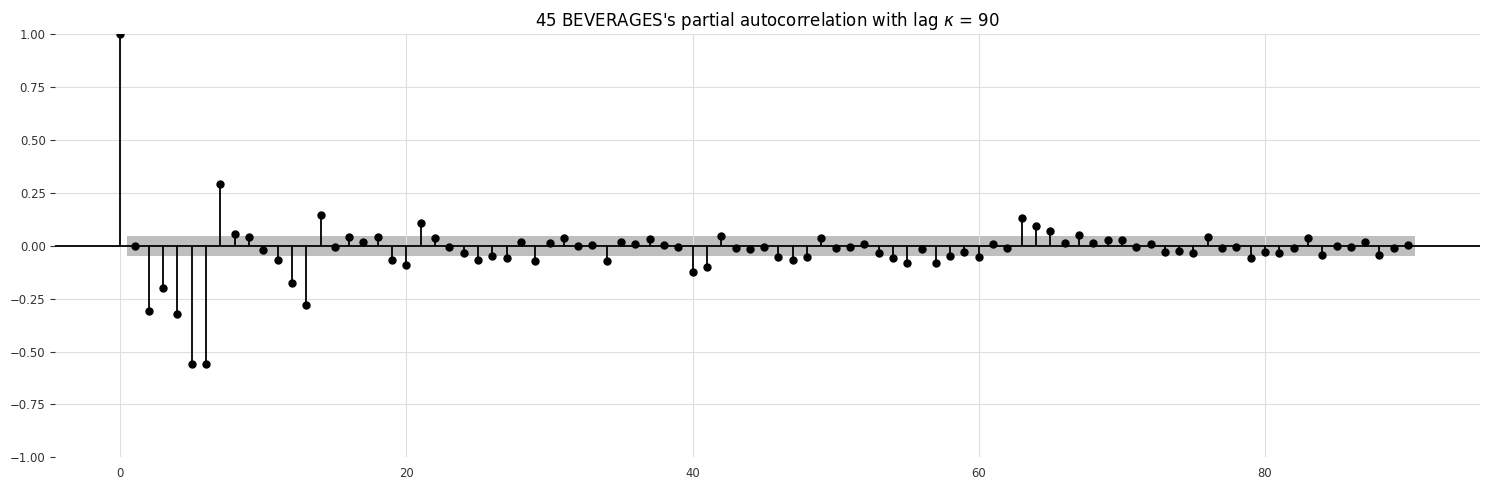

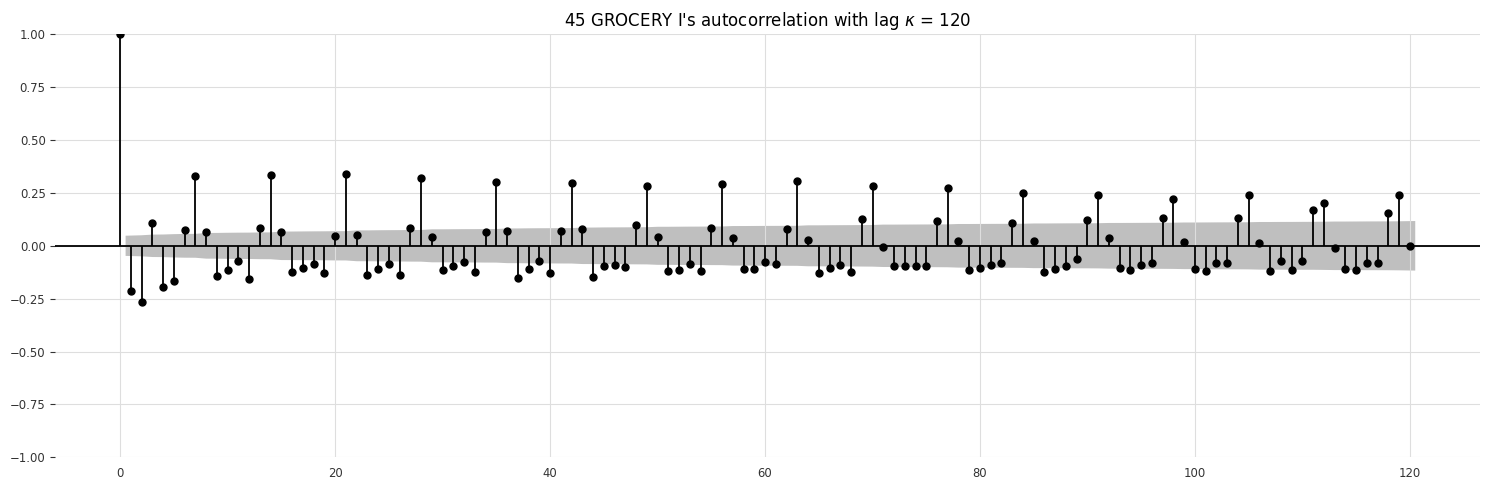

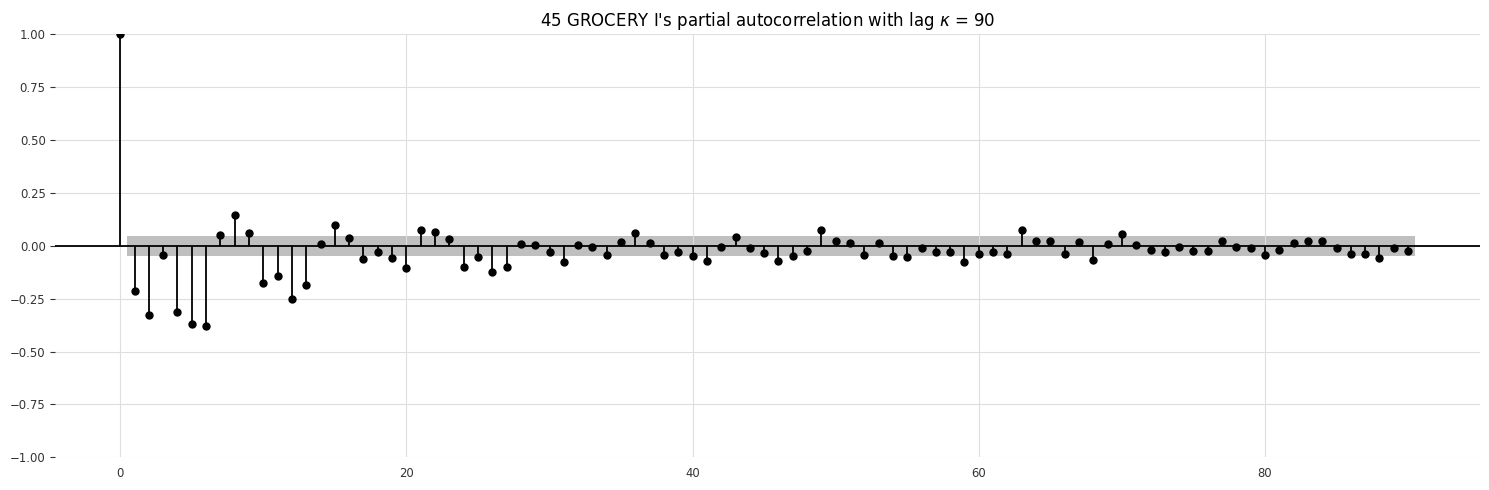

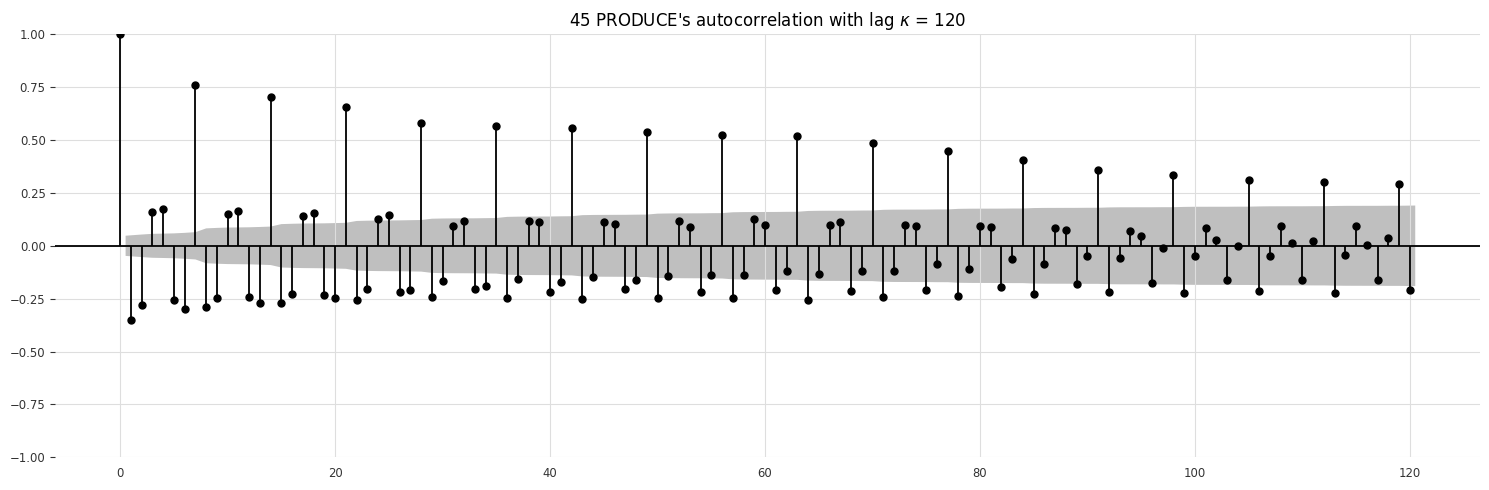

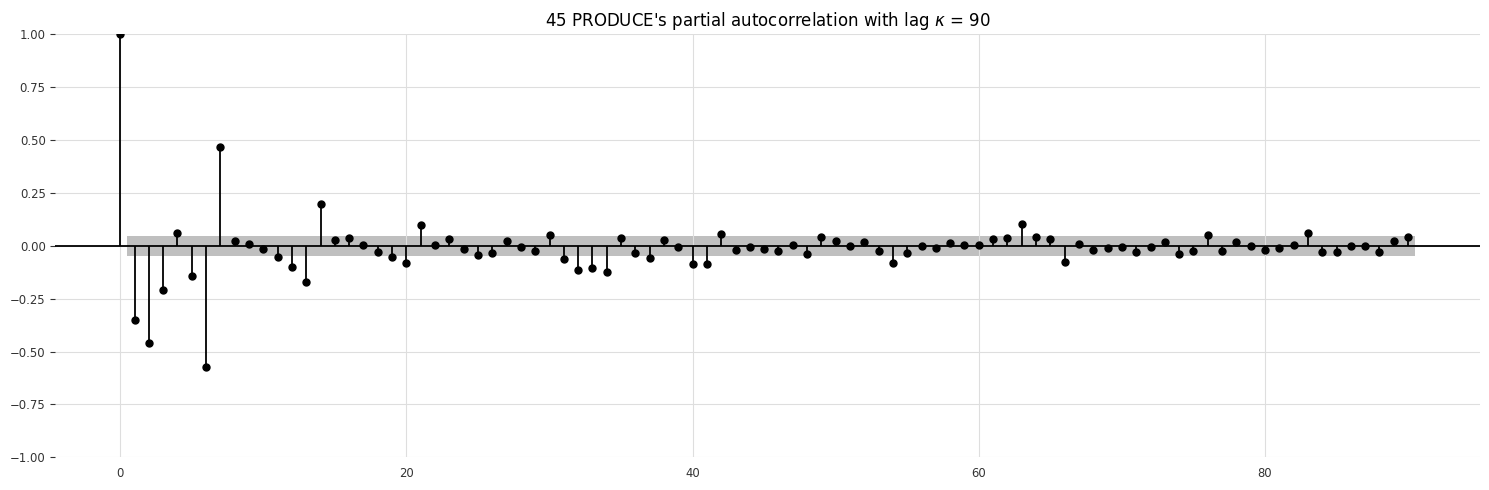

In [8]:
for product in top_series.columns:
    diff_series, lags_ac, lags_pac, lags_indexes_pac = functions.check_autocorrelation(series=product, diff_lags=1)
    dict_diff_series[product] = (diff_series, lags_ac, lags_pac, lags_indexes_pac)

In [9]:
performance_dict = {}
performance_dict['Series'] = []

In [10]:
performance_dict['Baseline mape'] = []

performance_dict['Arima mape'] = []

In [11]:
#performance_dict['Random Forest mape'] = []

In [12]:
# performance_dict['Arima mape scaled data'] = []
# performance_dict['Arima mape scaled data and weeks'] = []

# performance_dict['Random Forest more cov mape and weeks 1'] = []
# performance_dict['Random Forest no diff mape'] = []

# performance_dict['LSTM mape'] = []
# performance_dict['LSTM val mape'] = []

**Creazione serie multivariata**

In [13]:
multi_series = TimeSeries.from_dataframe(df=top_series, value_cols=None, freq='D', fill_missing_dates=True)

multi_series[:3]

<TimeSeries (DataArray) (time: 3, component: 6, sample: 1)>
array([[[ 5466.],
        [10686.],
        [   57.],
        [ 4070.],
        [11422.],
        [   47.]],

       [[ 5466.],
        [10686.],
        [   57.],
        [ 4070.],
        [11422.],
        [   47.]],

       [[ 3718.],
        [ 7342.],
        [   57.],
        [ 2526.],
        [ 6841.],
        [   47.]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 2013-01-03
  * component  (component) object '44 BEVERAGES' '44 GROCERY I' ... '45 PRODUCE'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

**Creazione serie differenziata multivariata**

In [ ]:
darts_series = []
for product in dict_diff_series.keys():
    diff_series = dict_diff_series[product][0]
    
    diff_series = TimeSeries.from_series(diff_series, freq='D', fill_missing_dates=True)
    darts_series.append(diff_series)
multi_diff_series = darts_series[0]
for series in darts_series[1:]:
    multi_diff_series = multi_diff_series.stack(series)

**Creazione dizionario lags**

In [36]:
dict_series = {}
for category in top_series.columns:
    series = top_series[category]
    part_corr = functions.pacf(x=series, nlags=30)
    lags_pac = [(i+1, round(c, 3)) for i, c in enumerate(part_corr[1:]) if abs(c) >= 0.175] #0.25
    
    lags_indexes_pac = [int(t[0])*(-1) for t in lags_pac]
    dict_series[category] = lags_indexes_pac

dict_series

{'44 BEVERAGES': [-1, -2, -3, -5, -6, -7, -8, -13, -14],
 '44 GROCERY I': [-1, -6, -7, -13, -14],
 '44 PRODUCE': [-1, -2, -3, -4, -7, -8, -14, -15],
 '45 BEVERAGES': [-1, -3, -5, -6, -7, -8, -14],
 '45 GROCERY I': [-1, -6, -7, -9, -13, -14],
 '45 PRODUCE': [-1, -2, -3, -4, -7, -8, -14, -15]}

Considereremo i primi 14 lags

**Baseline model**

In [25]:
from darts.models import NaiveSeasonal

def get_naive_predictions(multi_series: TimeSeries):
    #series = TimeSeries.from_series(top_series[series], freq='D', fill_missing_dates=True)
    partial = multi_series[-227:]  # dall'inizio dell'anno 2017

    # otteniamo le predizioni
    naive_model = NaiveSeasonal(K=7)
    naive_model.fit(partial[:-28])
    naive_forecast = naive_model.predict(28)

    # rappresentiamo il grafico
    fig, ax = plt.subplots(figsize=(15, 5))
    partial[-90:].plot(lw=4, label="actual", ax=ax)
    naive_forecast.plot(lw=2, label="naive forecast (K=7)", ax=ax)
    plt.title(r'Naive Seasonal weekly moving average forecast')
    plt.tight_layout()
    plt.show()
    
    # calcoliamo mape
    mape = functions.measure_mape(model='Naive Seasonal', test=partial[-28:], pred=naive_forecast)
    return mape

In [28]:
performance_dict['Baseline mape'] = [23.47, 12.06, 7.33, 15.54, 11.05, 8.72]
# baseline_mape = get_naive_predictions(multi_series=multi_series)
# performance_dict['Baseline mape'].append(baseline_mape)

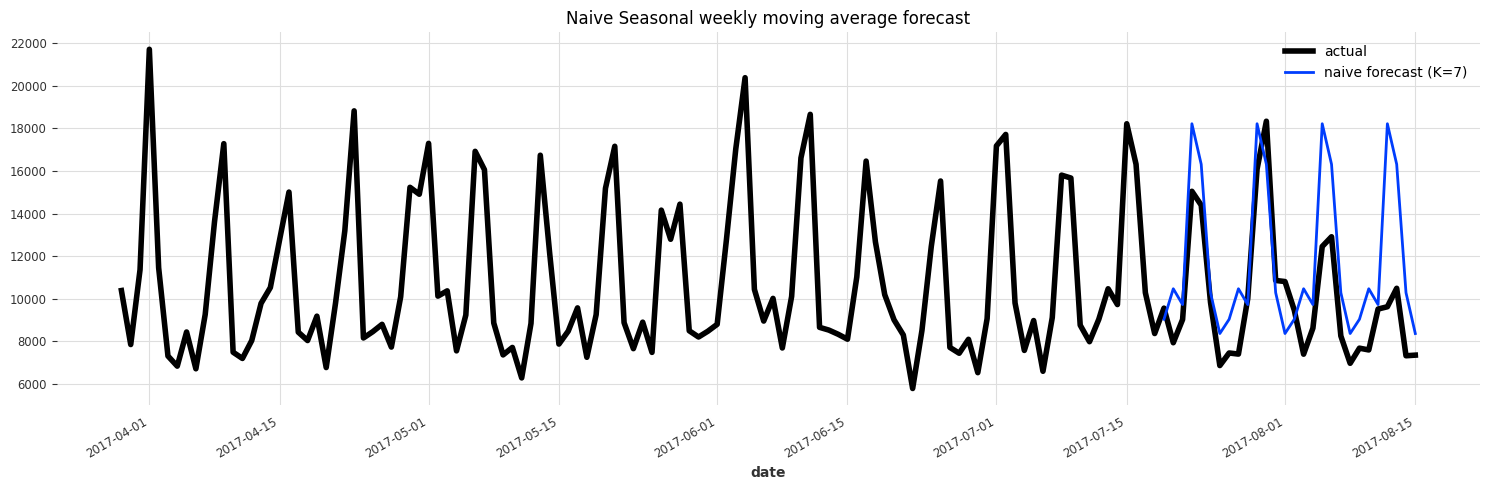

model Naive Seasonal obtains MAPE: 23.47


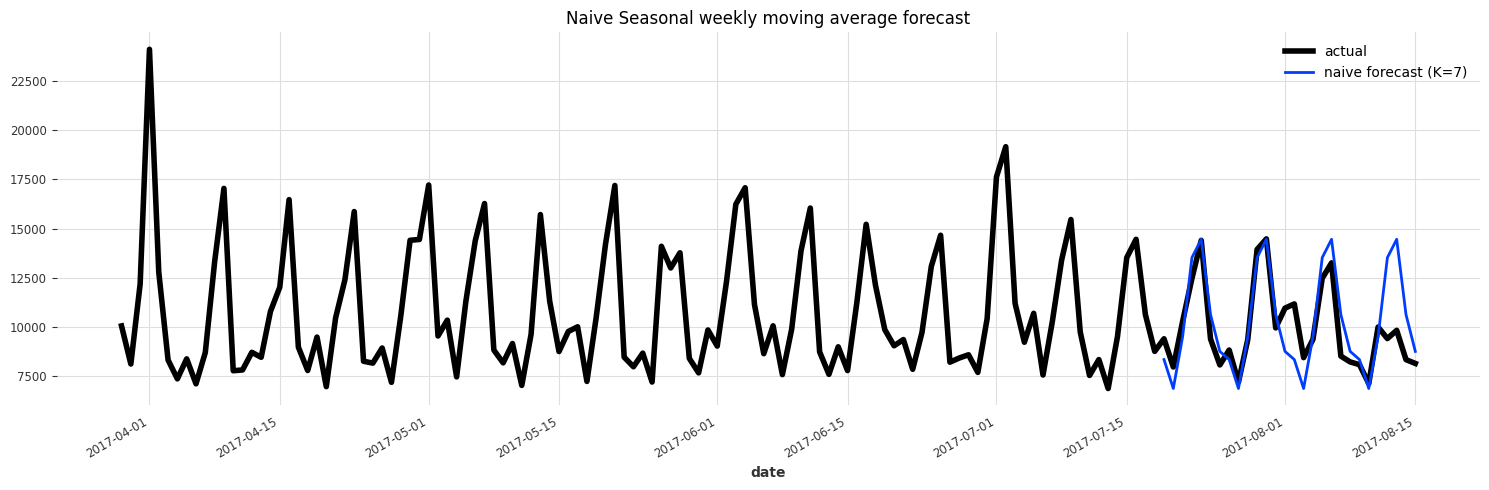

model Naive Seasonal obtains MAPE: 12.06


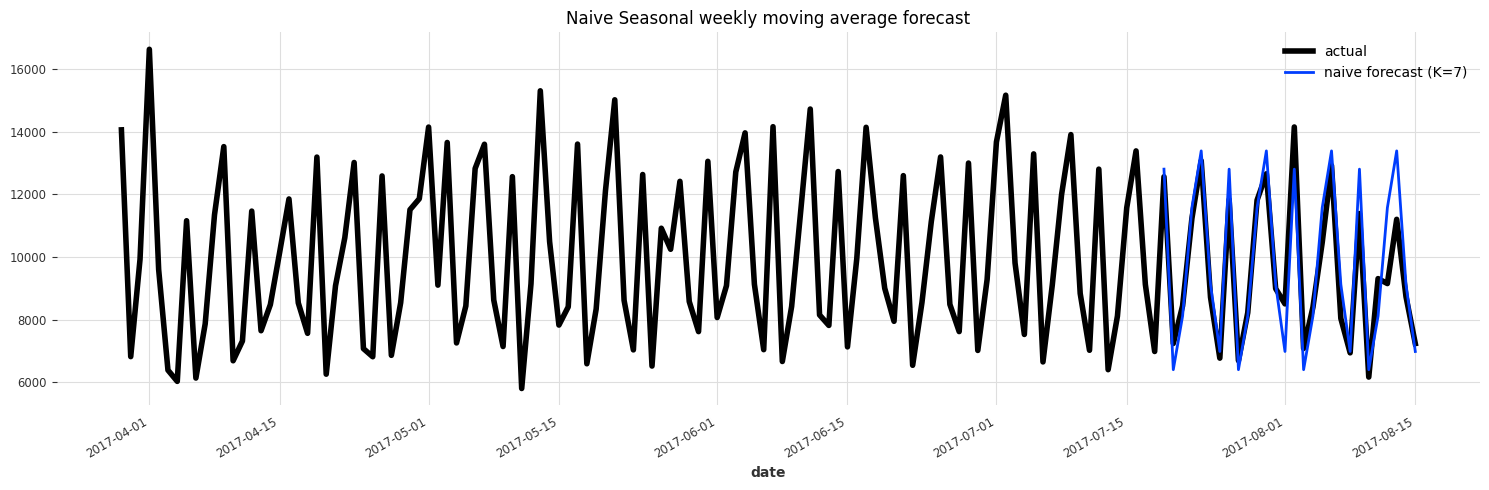

model Naive Seasonal obtains MAPE: 7.33


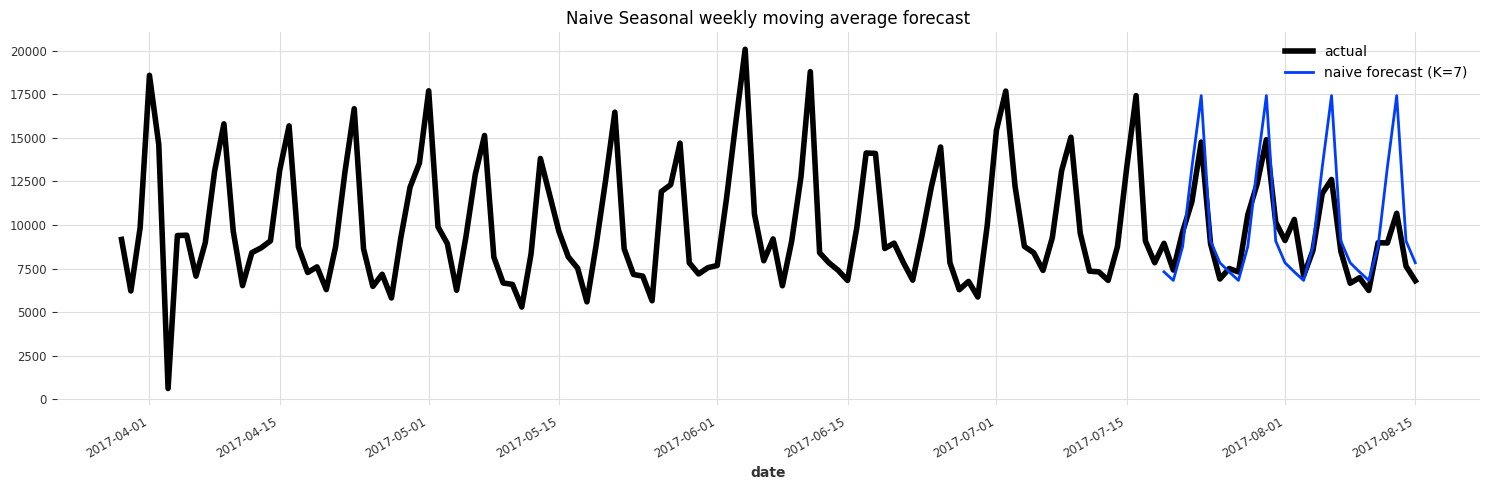

model Naive Seasonal obtains MAPE: 15.54


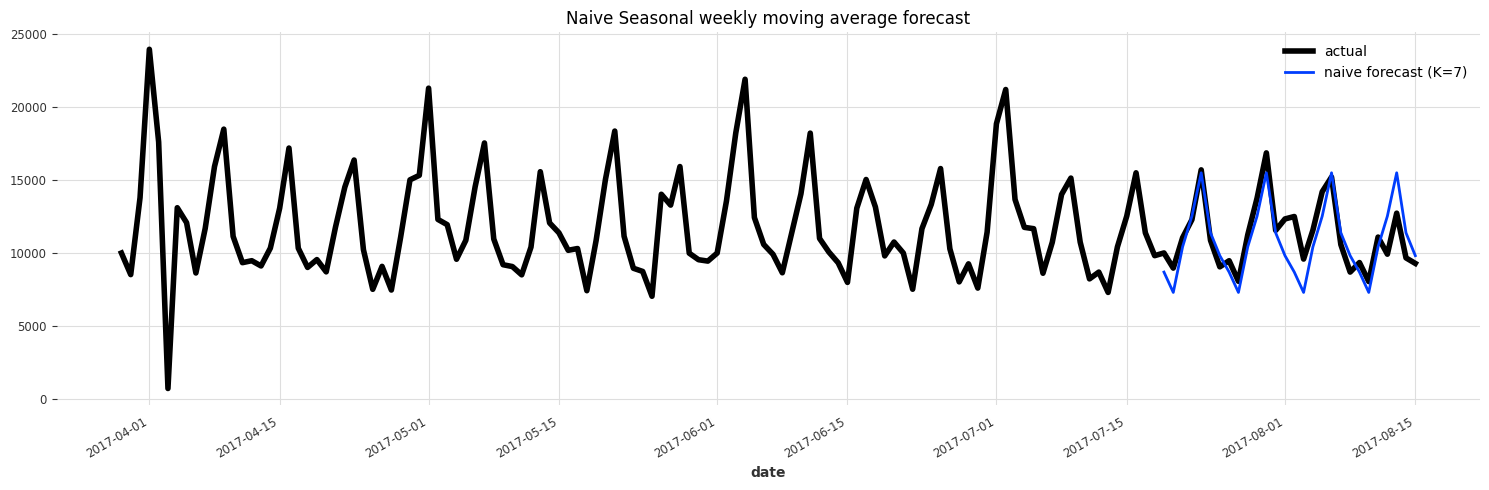

model Naive Seasonal obtains MAPE: 11.05


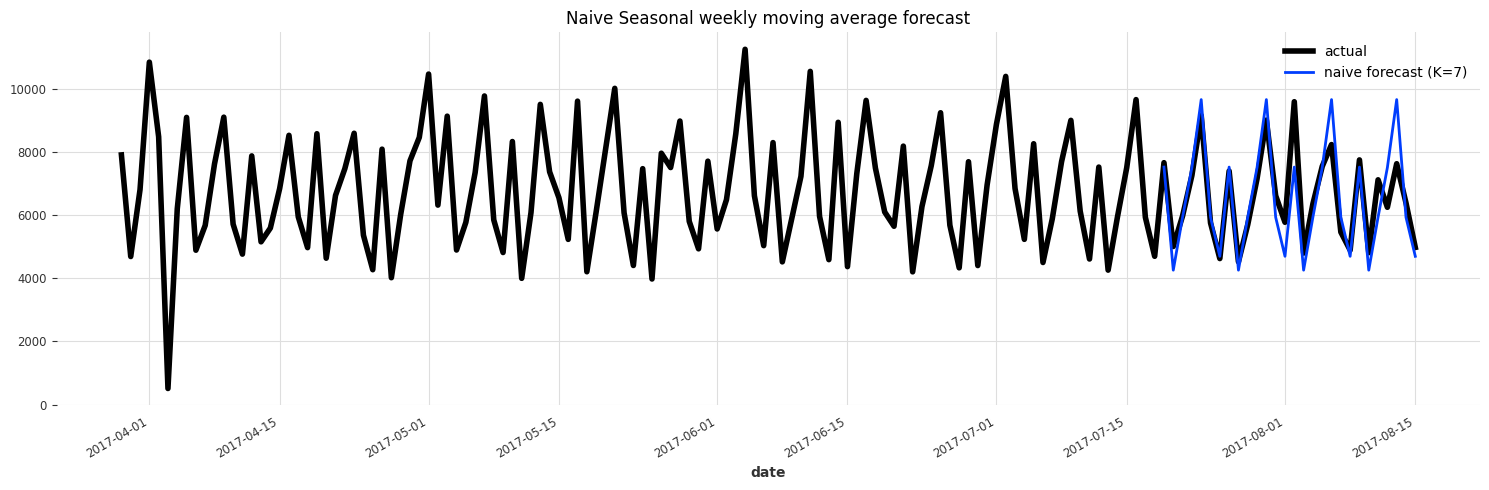

model Naive Seasonal obtains MAPE: 8.72


In [15]:
# performance_dict['Baseline mape'] = []
# for product in top_series.columns:
#     baseline_mape = functions.get_naive_predictions(series=product)
#     performance_dict['Baseline mape'].append(baseline_mape)

In [29]:
performance_dict['Baseline mape']

[23.47, 12.06, 7.33, 15.54, 11.05, 8.72]

**VARIMA**

**VECTOR Arima model**

In [293]:
from darts.dataprocessing.transformers import Scaler
from darts.models.forecasting.varima import VARIMA

def get_varima_predictions(series: TimeSeries, p: int, d: int = 1, q: int = 0, trend: str = 'n',
                          to_scale: bool = False, fut_cov_days_only: bool = True, week_of_year: bool = False,
                          lags_future_covariates: list = [-1, 0], return_pred: bool = True):

    #nome serie
    name = series.components
    print(name)
    
    #Divisione train e test
    #train = series[392:-28] #52 settimane di train
    train = series[:-28]
    test = series[-28:]
    
    #Scalatura dei dati, è meglio fare il fit solo sul train
    if to_scale == True:
        scaler = Scaler()
        train = scaler.fit_transform(train)
    
    #Aggiunta covariate future
    covariates = functions.get_datetime_series(series=series, days_only=fut_cov_days_only, week_of_year=week_of_year)
    
    #Predizione
    model = VARIMA(p=p, d=d, q=q, trend=trend)
    model.fit(series=train, future_covariates=covariates)
    pred = model.predict(n=28, future_covariates=covariates)

    #Invertire la scalatura dei dati
    if to_scale == True:
        pred = scaler.inverse_transform(pred)
    
    #Calcolo mape come metrica di errore
    model_mape = functions.measure_mape(model='arima', test=test, pred=pred)

    #restituire le predizioni
    if return_pred == True:
        return pred, model_mape
    else:
        return model_mape

In [294]:
varima_pred_week, varima_mape_week = get_varima_predictions(series=multi_series, p=7, d=1, q=3,
                                                            fut_cov_days_only=True, to_scale=True, return_pred=True)
performance_dict['Arima mape_week'] = varima_mape_week

Index(['44 BEVERAGES', '44 GROCERY I', '44 PRODUCE', '45 BEVERAGES',
       '45 GROCERY I', '45 PRODUCE'],
      dtype='object', name='component')
model arima obtains MAPE: 39.28


KeyError: 'Arima mape_week'

model arima obtains MAPE: 39.28

In [296]:
varima_pred_week.to_csv('./data/varima_pred/varima_pred_week.csv')
df_varima_pred_week = pd.read_csv('./data/varima_pred/varima_pred_week.csv', index_col='time', parse_dates=True)
#df_varima_pred_week.head(5)

In [59]:
varima_pred_scaled, varima_mape_scaled = get_varima_predictions(series=multi_series, p=14, fut_cov_days_only=True, to_scale=True, return_pred=True)
performance_dict['Arima mape'].append(varima_mape)

Index(['44 BEVERAGES', '44 GROCERY I', '44 PRODUCE', '45 BEVERAGES',
       '45 GROCERY I', '45 PRODUCE'],
      dtype='object', name='component')
model arima obtains MAPE: 49.10


model arima obtains MAPE: 49.10

solo le serie univariate supportano il metodo pd_series(), provare pd_dataframe() per le multivariate, nel caso.

In [84]:
#varima_pred_scaled.to_csv('./data/varima_pred/varima_pred_diff_49.csv')
df_varima_pred_scaled = pd.read_csv('./data/varima_pred/varima_pred_diff_49.csv', index_col='time', parse_dates=True)
#df_varima_pred_scaled.head(5)

,44 BEVERAGES,44 GROCERY I,44 PRODUCE,45 BEVERAGES,45 GROCERY I,45 PRODUCE
time,,,,,,
2017-07-19,11365.90,10723.03,14104.68,10742.12,13785.03,8920.85
2017-07-20,10388.51,7486.48,7818.26,8626.65,2298.73,6306.87
2017-07-21,10517.19,9784.58,10294.35,10085.38,16046.58,6811.38
2017-07-22,17685.25,15110.97,12243.07,14218.55,10865.97,7006.81
2017-07-23,15894.02,15422.05,13463.77,16712.65,20695.72,9474.62


In [65]:
varima_pred_no_scale, varima_mape_no_scale = get_varima_predictions(series=multi_series, p=14, fut_cov_days_only=True,
                                                                    to_scale=False, return_pred=True)
performance_dict['Arima mape_not_scaled'] = varima_mape

Index(['44 BEVERAGES', '44 GROCERY I', '44 PRODUCE', '45 BEVERAGES',
       '45 GROCERY I', '45 PRODUCE'],
      dtype='object', name='component')
model arima obtains MAPE: 18.95


In [83]:
# df_varima_pred = varima_pred_no_scale.pd_dataframe()
# df_varima_pred.rename_axis(None, axis='columns', inplace=True)
# df_varima_pred.head(5)

In [82]:
#varima_pred_no_scale.to_csv('./data/varima_pred/varima_pred_diff_19.csv')
df_varima_pred_no_scale = pd.read_csv('./data/varima_pred/varima_pred_diff_19.csv', index_col='time', parse_dates=True)
#df_varima_pred_no_scale.head(5)

,44 BEVERAGES,44 GROCERY I,44 PRODUCE,45 BEVERAGES,45 GROCERY I,45 PRODUCE
time,,,,,,
2017-07-19,7770.64,7375.59,10575.24,7871.23,8629.02,7317.72
2017-07-20,10869.00,11288.25,9888.14,9276.15,11504.11,5829.48
2017-07-21,10943.60,9119.01,8628.22,10414.84,9963.03,6476.72
2017-07-22,16531.37,16240.43,13198.65,15067.49,17393.22,8430.68
2017-07-23,16269.60,13903.71,12084.51,15719.40,15227.31,8946.24


model arima obtains MAPE: 18.95

In [67]:
varima_pred_13, varima_mape_13 = get_varima_predictions(series=multi_series, p=13, d=1, fut_cov_days_only=True,
                                                                    to_scale=True, return_pred=True)
performance_dict['Arima mape_13'] = varima_mape

Index(['44 BEVERAGES', '44 GROCERY I', '44 PRODUCE', '45 BEVERAGES',
       '45 GROCERY I', '45 PRODUCE'],
      dtype='object', name='component')
model arima obtains MAPE: 73.88


model arima obtains MAPE: 73.88

In [86]:
#varima_pred_13.to_csv('./data/varima_pred/varima_pred_diff_74.csv')
df_varima_pred_13_lags = pd.read_csv('./data/varima_pred/varima_pred_diff_74.csv', index_col='time', parse_dates=True)
#df_varima_pred_13_lags.head(5)

,44 BEVERAGES,44 GROCERY I,44 PRODUCE,45 BEVERAGES,45 GROCERY I,45 PRODUCE
time,,,,,,
2017-07-19,10822.36,11039.62,10997.93,10532.22,12333.98,8084.81
2017-07-20,9118.07,9280.29,7942.67,6807.43,4848.88,5027.93
2017-07-21,11783.92,10528.02,18233.64,9794.84,20955.43,5960.66
2017-07-22,18854.32,17310.76,21115.27,13972.87,20535.78,7864.24
2017-07-23,17740.70,17800.77,20931.76,18082.76,25909.49,11040.17


In [63]:
varima_pred_no_diff, varima_mape_no_diff = get_varima_predictions(series=multi_series, p=14, d=0, fut_cov_days_only=True,
                                                                  to_scale=True, return_pred=True)
performance_dict['Arima mape_no_diff'] = varima_mape_no_diff

Index(['44 BEVERAGES', '44 GROCERY I', '44 PRODUCE', '45 BEVERAGES',
       '45 GROCERY I', '45 PRODUCE'],
      dtype='object', name='component')
model arima obtains MAPE: 11.11


model arima obtains MAPE: 11.11

In [87]:
#varima_pred_no_diff.to_csv('./data/varima_pred/varima_pred_no_diff_11.csv')
df_varima_pred_no_diff = pd.read_csv('./data/varima_pred/varima_pred_no_diff_11.csv', index_col='time', parse_dates=True)
#df_varima_pred_no_diff.head(5)

,44 BEVERAGES,44 GROCERY I,44 PRODUCE,45 BEVERAGES,45 GROCERY I,45 PRODUCE
time,,,,,,
2017-07-19,9647.12,10269.81,12678.46,7755.35,10265.44,7418.43
2017-07-20,9022.98,8201.76,7367.51,7487.06,8134.67,4571.25
2017-07-21,10543.98,9767.93,9486.08,9479.46,11064.20,6406.78
2017-07-22,15407.75,14177.06,11654.81,13125.24,14460.20,7332.85
2017-07-23,16412.68,15769.34,13815.70,15641.77,16612.05,9571.35


In [72]:
individual_mape = []
components = [component for component in multi_series.components]
for component in components:
    pred = varima_pred_no_diff[component]
    test = multi_series[component][-28:]
    mape = functions.measure_mape(model='varima', test=test, pred=pred)
    individual_mape.append(mape)
print(individual_mape)

model varima obtains MAPE: 16.36
model varima obtains MAPE: 12.39
model varima obtains MAPE: 9.75
model varima obtains MAPE: 10.54
model varima obtains MAPE: 10.47
model varima obtains MAPE: 7.18
[16.36, 12.39, 9.75, 10.54, 10.47, 7.18]


model varima obtains MAPE: 16.36
model varima obtains MAPE: 12.39
model varima obtains MAPE: 9.75
model varima obtains MAPE: 10.54
model varima obtains MAPE: 10.47
model varima obtains MAPE: 7.18
[16.36, 12.39, 9.75, 10.54, 10.47, 7.18]

[16.36, 12.39, 9.75, 10.54, 10.47, 7.18] mape relativi ad ogni serie non differenziata, p=14, scale=true

44 BEVERAGES


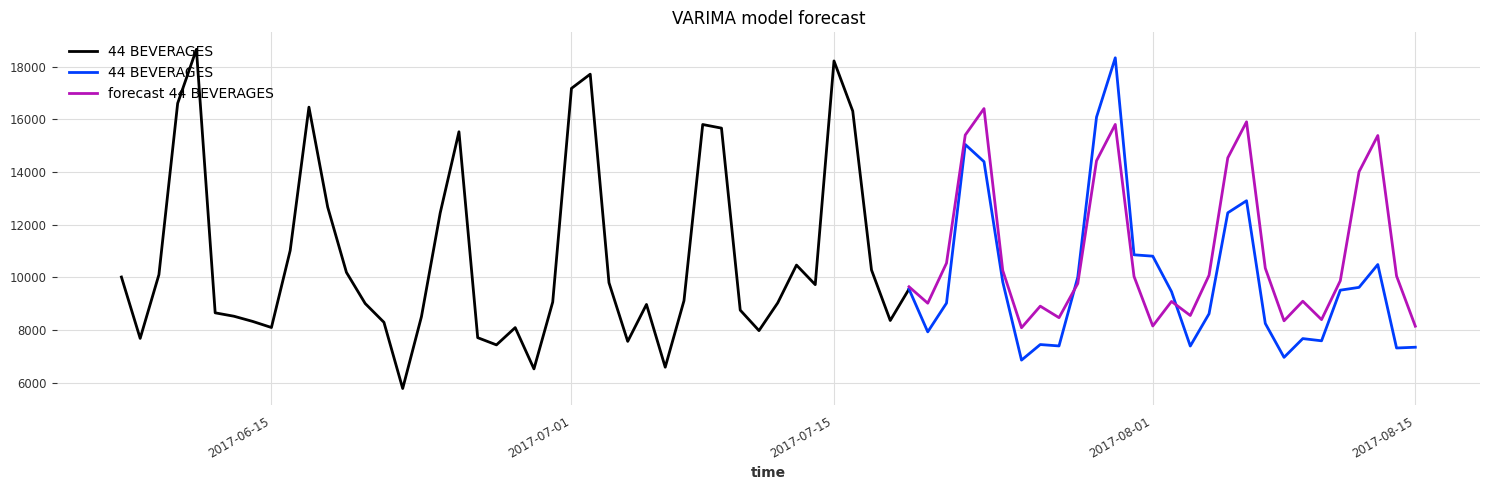

44 GROCERY I


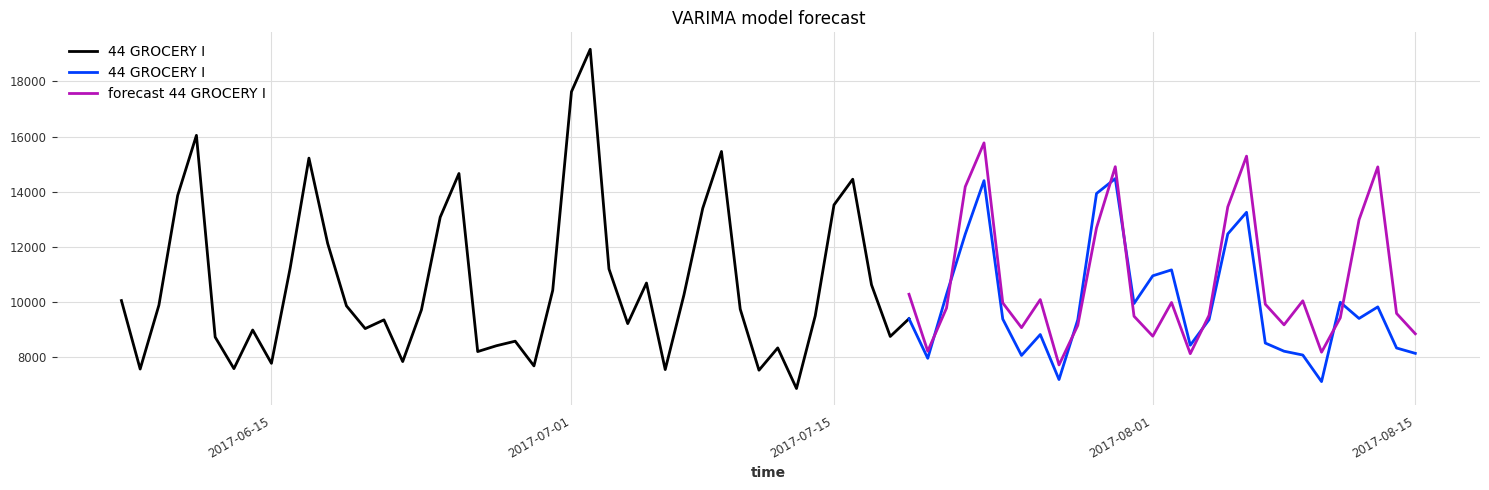

44 PRODUCE


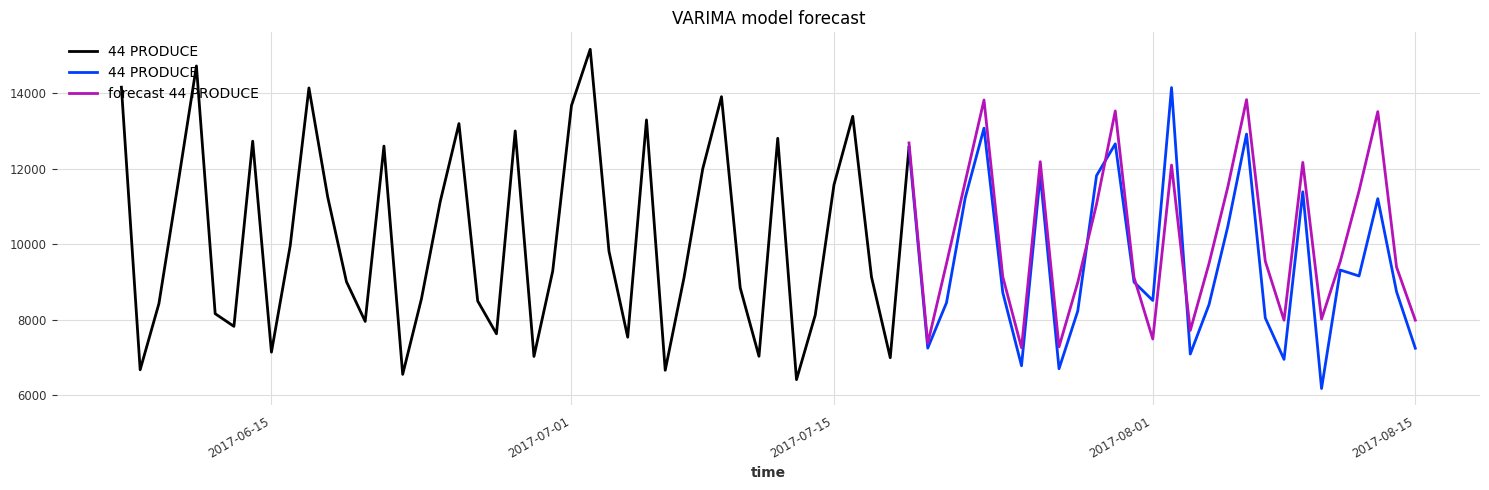

45 BEVERAGES


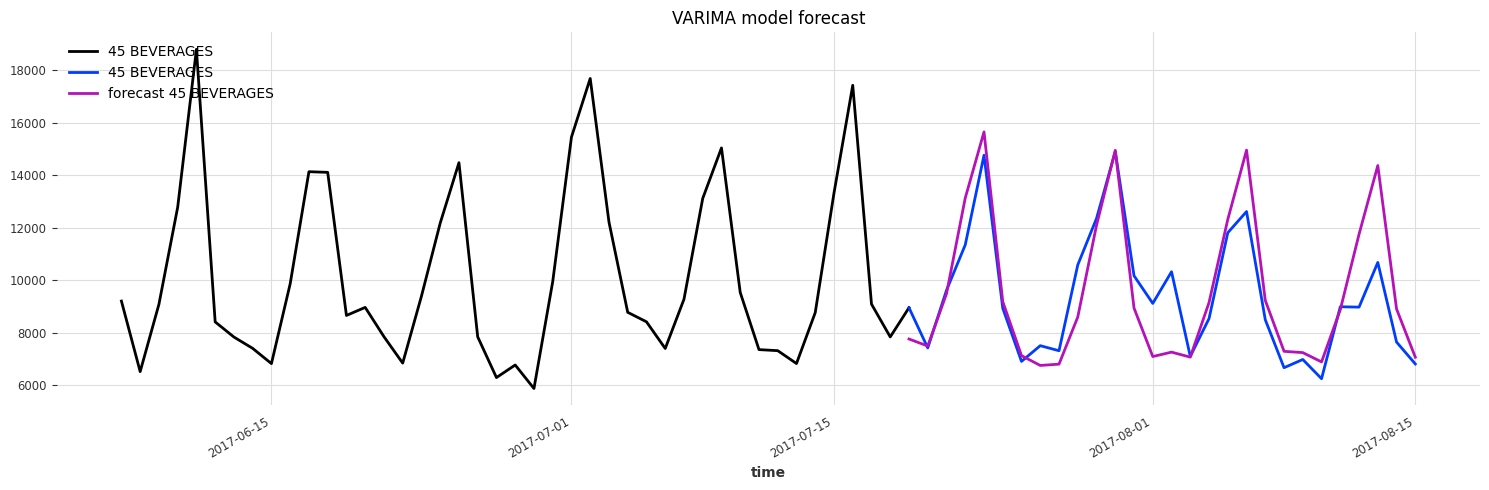

45 GROCERY I


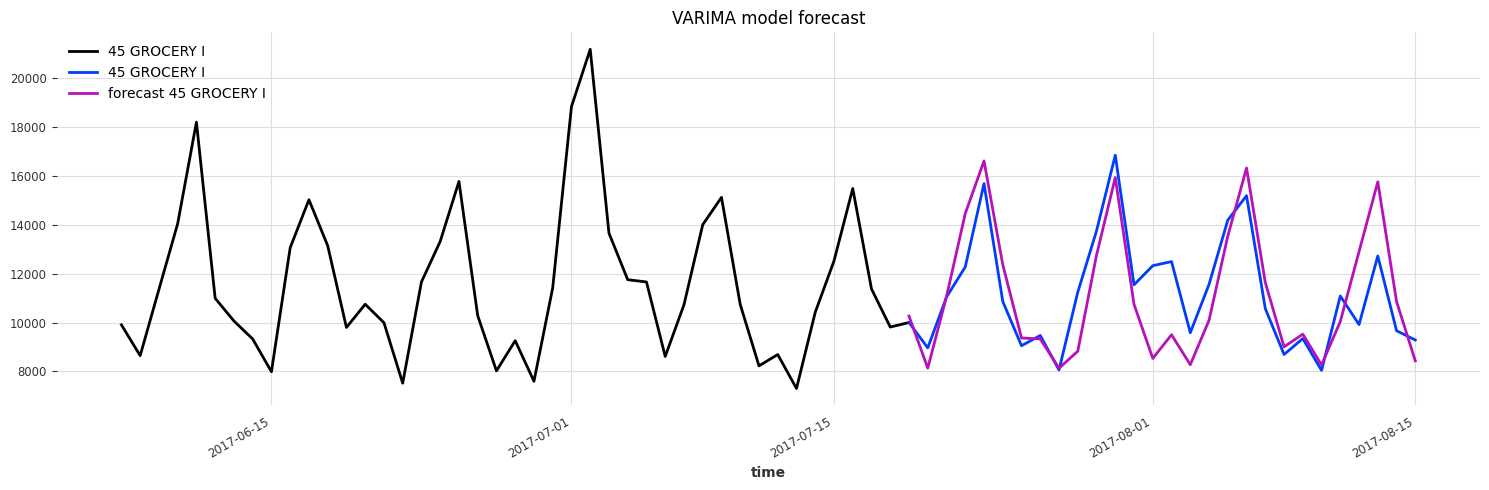

45 PRODUCE


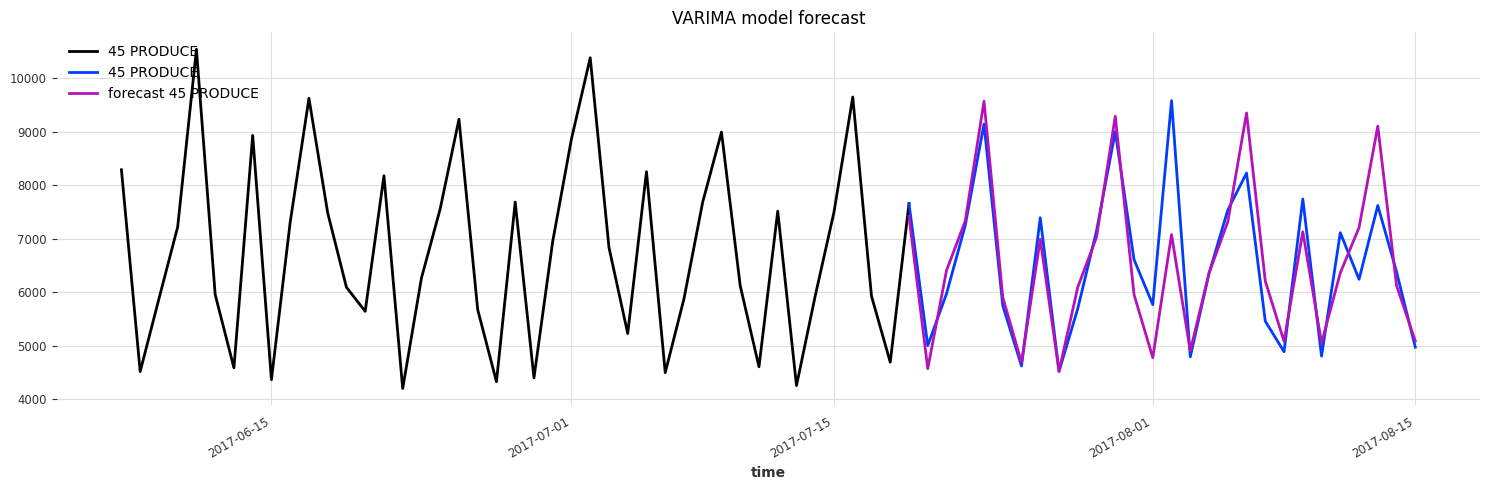

In [71]:
test = multi_series[-28:]
test_labels = [component for component in multi_series.components]
for component in test_labels:
    print(component)
    fig, ax = plt.subplots(figsize=(15, 5))
    #test.plot(label=test_labels, ax=ax)
    multi_series[component][-70:-27].plot(ax=ax)
    test[component].plot(ax=ax)
    label = f"forecast {component}"
    varima_pred_no_diff[component].plot(label=label, ax=ax)
    ax.set_title("VARIMA model forecast")
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

In [64]:
varima_pred_no_diff_no_scale, varima_mape_no_diff_no_scale = get_varima_predictions(series=multi_series, p=14, d=0, fut_cov_days_only=True,
                                                                  to_scale=False, return_pred=True)
performance_dict['Arima mape_no_diff_no_scale'] = varima_mape_no_diff_no_scale

Index(['44 BEVERAGES', '44 GROCERY I', '44 PRODUCE', '45 BEVERAGES',
       '45 GROCERY I', '45 PRODUCE'],
      dtype='object', name='component')
model arima obtains MAPE: 12.31


model arima obtains MAPE: 12.31

In [88]:
#varima_pred_no_diff_no_scale.to_csv('./data/varima_pred/varima_pred_no_diff_no_scale_12.csv')
df_varima_pred_no_diff_no_scale = pd.read_csv('./data/varima_pred/varima_pred_no_diff_no_scale_12.csv', index_col='time', parse_dates=True)
#df_varima_pred_no_diff_no_scale.head(5)

,44 BEVERAGES,44 GROCERY I,44 PRODUCE,45 BEVERAGES,45 GROCERY I,45 PRODUCE
time,,,,,,
2017-07-19,9568.41,9960.56,13014.68,7444.61,9645.98,7637.25
2017-07-20,9302.79,8417.49,7626.66,7819.98,8795.71,4762.76
2017-07-21,10261.91,9397.26,9847.19,9358.93,11076.02,6510.10
2017-07-22,16013.56,15094.31,11905.70,13606.07,15095.52,7499.87
2017-07-23,16288.17,15425.67,13986.50,15619.96,16338.56,9606.36


In [75]:
varima_pred_trend, varima_mape_trend = get_varima_predictions(series=multi_series, p=14, d=0, trend='t', fut_cov_days_only=True,
                                                                  to_scale=True, return_pred=True)
performance_dict['Arima mape_trend'] = varima_mape_trend

Index(['44 BEVERAGES', '44 GROCERY I', '44 PRODUCE', '45 BEVERAGES',
       '45 GROCERY I', '45 PRODUCE'],
      dtype='object', name='component')
model arima obtains MAPE: 18.41


model arima obtains MAPE: 18.41

In [89]:
#varima_pred_trend.to_csv('./data/varima_pred/varima_pred_trend_18.csv')
df_varima_pred_trend = pd.read_csv('./data/varima_pred/varima_pred_trend_18.csv', index_col='time', parse_dates=True)
#df_varima_pred_trend.head(5)

,44 BEVERAGES,44 GROCERY I,44 PRODUCE,45 BEVERAGES,45 GROCERY I,45 PRODUCE
time,,,,,,
2017-07-19,8997.45,8852.08,12194.59,7195.27,9947.90,6974.84
2017-07-20,9748.72,9011.09,8453.96,8135.55,9628.81,5093.26
2017-07-21,11885.01,11423.11,11555.46,10529.81,11293.73,7623.31
2017-07-22,14950.49,13899.58,12142.19,13385.99,13859.58,7938.20
2017-07-23,15946.79,15513.53,13884.55,15552.91,16436.37,9959.29


**RANDOM FOREST**

In [152]:
dict_series = {}
for category in top_series.columns:
    series = top_series[category]
    part_corr = functions.pacf(x=series, nlags=30)
    lags_pac = [(i+1, round(c, 3)) for i, c in enumerate(part_corr[1:]) if abs(c) >= 0.175] #0.2
    
    lags_indexes_pac = [int(t[0])*(-1) for t in lags_pac]
    dict_series[category] = lags_indexes_pac

dict_series

{'44 BEVERAGES': [-1, -2, -3, -5, -6, -7, -8, -13, -14],
 '44 GROCERY I': [-1, -6, -7, -13, -14],
 '44 PRODUCE': [-1, -2, -3, -4, -7, -8, -14, -15],
 '45 BEVERAGES': [-1, -3, -5, -6, -7, -8, -14],
 '45 GROCERY I': [-1, -5, -6, -7, -9, -13, -14],
 '45 PRODUCE': [-1, -2, -3, -4, -7, -8, -14, -15]}

In [153]:
from itertools import chain
all_lags_indexes = list(chain.from_iterable(dict_series.values()))
lags_indexes = sorted(list(set([i for i in all_lags_indexes if all_lags_indexes.count(i) >=4])), reverse=True)
#lags_indexes.append(-14) #eseguire quando pac >=0.2
lags_indexes

[-1, -3, -6, -7, -8, -14]

In [131]:
from darts.models.forecasting.random_forest import RandomForest

def get_rf_predictions(series: TimeSeries, lags_indexes: list, past_covariates: TimeSeries = None,
                          to_scale: bool = False, fut_cov_days_only: bool = True, week_of_year: bool = False,
                          lags_future_covariates: list = [-1, 0], lags_past_covariates: list = None, return_pred: bool = True):

    #nome serie
    name = series.components
    #print(name)
    
    #Divisione train e test
    #train = series[392:-28] #52 settimane di train
    train = series[:-28]
    test = series[-28:]
    
    #Scalatura dei dati, è meglio fare il fit solo sul train
    if to_scale == True:
        scaler = Scaler()
        train = scaler.fit_transform(train)
    
    #Aggiunta covariate future
    covariates = functions.get_datetime_series(series=series, days_only=fut_cov_days_only, week_of_year=week_of_year)
    
    #Predizione
    model = RandomForest(lags=lags_indexes, lags_future_covariates=lags_future_covariates,
                         lags_past_covariates=lags_past_covariates, n_estimators=100, random_state=3) #n_estimators=500
        
    model.fit(train, future_covariates=covariates, past_covariates=past_covariates)
    pred = model.predict(n=28, future_covariates=covariates, past_covariates=past_covariates)
    

    #Invertire la scalatura dei dati
    if to_scale == True:
        pred = scaler.inverse_transform(pred)
    
    #Calcolo mape come metrica di errore
    model_mape = functions.measure_mape(model='Random forest', test=test, pred=pred)
    
    #restituire le predizioni
    if return_pred == True:
        return pred, model_mape
    else:
        return model_mape

**Random Forest e serie non differenziate**

In [156]:
rf_pred_no_diff, rf_mape_no_diff = get_rf_predictions(series=multi_series, lags_indexes=lags_indexes, fut_cov_days_only=False,
                                                      week_of_year=False, to_scale=False, return_pred=True)
performance_dict['Rf mape_no_diff'] = rf_mape_no_diff

anno e giorni
model Random forest obtains MAPE: 11.03


In [157]:
rf_pred_no_diff.to_csv('./data/rf_pred/rf_pred_no_diff_11_3.csv')
df_rf_pred_no_diff = pd.read_csv('./data/rf_pred/rf_pred_no_diff_11_3.csv', index_col='time', parse_dates=True)
#df_rf_pred_no_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28 entries, 2017-07-19 to 2017-08-15
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   44 BEVERAGES  28 non-null     float64
 1   44 GROCERY I  28 non-null     float64
 2   44 PRODUCE    28 non-null     float64
 3   45 BEVERAGES  28 non-null     float64
 4   45 GROCERY I  28 non-null     float64
 5   45 PRODUCE    28 non-null     float64
dtypes: float64(6)
memory usage: 1.5 KB


In [133]:
rf_pred_days_only, rf_mape_days_only = get_rf_predictions(series=multi_series, lags_indexes=lags_indexes, fut_cov_days_only=True,
                                                      week_of_year=False, to_scale=False, return_pred=True)
performance_dict['Rf mape_days_only'] = rf_mape_days_only

model Random forest obtains MAPE: 11.13


**RECURRENT NEURAL NETWORK**

In [229]:
from darts.models import RNNModel
import torch
import torch.nn as nn
import torch.optim as optim
#import shutil
from torch.utils.tensorboard import SummaryWriter

def get_rnn_predictions_multi(diff_series: TimeSeries, lags_index: int = 13,
                            model_type: str = 'lstm', to_scale: bool = True, fut_cov_days_only: bool = True,
                            week_of_year: bool = False, return_pred: bool = True,
                            past_covariates: TimeSeries = None):
    # nome serie
    name = diff_series.components

    # Divisione train e test
    train = diff_series[-392:-28]  # un anno di dati = 52 settimane; /4 per trovare max_samples
    # train = series[:-28]
    test = diff_series[-28:]
    validation = diff_series[-42:-14]  # un mese di validation #-42

    # Scalatura dei dati, è meglio fare il fit solo sul train
    if to_scale == True:
        scaler = Scaler()
        train = scaler.fit_transform(train)
        validation = scaler.transform(validation)
        test_scaled = scaler.transform(test)

    # Aggiunta covariate future
    fut_cov = functions.get_datetime_series(series=diff_series, days_only=fut_cov_days_only, week_of_year=week_of_year)

    # Previsione RNN
    chunk_lenght = abs(lags_index)
    print(chunk_lenght)
    # chunk_lenght = 7
    # chunk_lenght = 28

    model_type = model_type.upper()
    rnn = RNNModel(model=model_type,
                   hidden_dim=25,  # 20
                   n_rnn_layers=1,  # 2
                   dropout=0.025,  # 0,
                   batch_size=8,  # 16
                   n_epochs=60,  # 50
                   # loss_fn=nn.L1Loss(),
                   loss_fn=nn.MSELoss(),
                   optimizer_kwargs={"lr": 1e-3},
                   random_state=42,
                   input_chunk_length=chunk_lenght,
                   output_chunk_length=1,
                   model_name="Sales_RNN",
                   log_tensorboard=True,
                   force_reset=True,
                   save_checkpoints=True
                   )

    # consideriamo solo gli ultimi 80 samples circa per il training
    max_samples = int(((len(train) + 1) - chunk_lenght) / 4)  # oppure 4; 20 se train = series[:-28]
    print(max_samples)

    # fit e predict
    rnn.fit(train, future_covariates=fut_cov, max_samples_per_ts=max_samples,
            val_series=validation, val_future_covariates=fut_cov, verbose=True)

    # Use the best model obtained over training, according to validation loss:
    best_model = RNNModel.load_from_checkpoint(model_name="Sales_RNN", best=True)

    pred = best_model.predict(n=28, future_covariates=fut_cov)

    # Calcolo mape come metrica di errore
    #test = original_series[-28:]
    model_mape = functions.measure_mape(model=model_type, test=test_scaled, pred=pred)

    #Invertire la scalatura dei dati
    if to_scale == True:
        pred = scaler.inverse_transform(pred)
    
    if return_pred == True:
        return pred, model_mape

    return model_mape

In [230]:
lags = []
for series in dict_diff_series.keys():
    lags_indexes = dict_diff_series[series][3]
    print(series, lags_indexes)
    for i in lags_indexes:
        lags.append(i)
lags_set = sorted(list(set([i for i in lags if lags.count(i) >= 4])), reverse=True)
print(lags_set)
lags_index = lags_set[-1]

44 BEVERAGES [-2, -4, -5, -6, -7, -12, -13]
44 GROCERY I [-1, -2, -3, -4, -5, -6, -12, -13]
44 PRODUCE [-1, -2, -3, -6, -7, -14]
45 BEVERAGES [-2, -3, -4, -5, -6, -7, -13]
45 GROCERY I [-1, -2, -4, -5, -6, -12, -13]
45 PRODUCE [-1, -2, -3, -6, -7, -14]
[-1, -2, -3, -4, -5, -6, -7, -13]


In [231]:
#mape_lstm = []
lstm_pred, lstm_mape = get_rnn_predictions_multi(diff_series=multi_diff_series, model_type='lstm', lags_index=7,
                                fut_cov_days_only=True, to_scale=True)
lstm_mape

2023-03-07 22:21:27 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2023-03-07 22:21:27 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2023-03-07 22:21:27 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2023-03-07 22:21:27 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2023-03-07 22:21:27 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 4.0 K 
4 | V             | Linear           | 156   
---------------------------------------------------
4.2 K     Trainable params
0         Non-trainable params
4.2 K     Total params
0.033     Total estimated model params size (MB)


7
89


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-03-07 22:21:51 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=60` reached.
2023-03-07 22:21:51 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2023-03-07 22:21:51 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2023-03-07 22:21:51 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2023-03-07 22:21:51 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

model LSTM obtains MAPE: 9.34


In [242]:
performance_dict['LSTM val mape'] = lstm_mape

In [189]:
lstm_pred.to_csv('./data/lstm_pred/lstm_pred_09_6.csv')
df_lstm_pred = pd.read_csv('./data/lstm_pred/lstm_pred_09_6.csv', index_col='date', parse_dates=True)
df_lstm_pred.head(2)

,44 BEVERAGES,44 GROCERY I,44 PRODUCE,45 BEVERAGES,45 GROCERY I,45 PRODUCE
date,,,,,,
2017-07-19,1115.06,1727.93,5420.14,948.95,1170.56,3249.05
2017-07-20,-1921.13,-2485.26,-5625.85,-1826.83,-1889.79,-3787.12


**inserire funzione sotto nella funzione lstm**

In [238]:
def get_not_diff_predictions_multi(pred: TimeSeries):
    pred_series = []
    for component in pred.components:
        #print(component)
        predictions = pred[component].pd_series()
        #print(predictions[:3])
        ind = predictions.index.to_list()

        real_pred = []
        #print(top_series[component]['2017-07-18'])
        real_pred.append(predictions[0]+top_series[component]['2017-07-18'])
        for i in predictions[1:]:
            lag = real_pred[-1]
            real_pred.append(round(i+lag, 2))

        real_pred = pd.Series(data=real_pred, index=ind, name=component)
        real_pred.index.rename('date', inplace=True)
        real_pred = TimeSeries.from_series(real_pred, freq='D', fill_missing_dates=True)
        #print(real_pred[:2])
        pred_series.append(real_pred)
        
    multi_preds = pred_series[0]
    for series in pred_series[1:]:
        multi_preds = multi_preds.stack(series)
    
    return multi_preds

In [239]:
lstm_multi_pred_no_diff = get_not_diff_predictions_multi(lstm_pred)

date
2017-07-19     824.97
2017-07-20   -1488.91
2017-07-21    2791.96
Freq: D, dtype: float64
8366.0
<TimeSeries (DataArray) (date: 2, component: 1, sample: 1)>
array([[[9190.96979409]],

       [[7702.06      ]]])
Coordinates:
  * date       (date) datetime64[ns] 2017-07-19 2017-07-20
  * component  (component) object '44 BEVERAGES'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
date
2017-07-19    1188.23
2017-07-20   -2074.35
2017-07-21    3101.22
Freq: D, dtype: float64
8737.0
<TimeSeries (DataArray) (date: 2, component: 1, sample: 1)>
array([[[9925.22744361]],

       [[7850.87      ]]])
Coordinates:
  * date       (date) datetime64[ns] 2017-07-19 2017-07-20
  * component  (component) object '44 GROCERY I'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
date
2017-07-19    5725.33
2017-07-20   -6058.47
2017-07-21    2257.91
Freq: D, dtype: float64
6987.988
<Tim

In [233]:
lstm_not_diff_mape = functions.measure_mape(model='lightgbm', test=multi_series[-28:], pred=lstm_multi_pred_no_diff)

model lightgbm obtains MAPE: 11.66


In [246]:
lstm_multi_pred_no_diff.to_csv('./data/lstm_pred/lstm_pred_11_7.csv')
df_lstm_pred = pd.read_csv('./data/lstm_pred/lstm_pred_11_7.csv', index_col='date', parse_dates=True)
df_lstm_pred.head(2)

,44 BEVERAGES,44 GROCERY I,44 PRODUCE,45 BEVERAGES,45 GROCERY I,45 PRODUCE
date,,,,,,
2017-07-19,9190.97,9925.23,12713.32,7974.08,9853.99,8105.62
2017-07-20,7702.06,7850.87,6654.85,6498.33,8224.80,4328.56


**DATAFRAME DELLE PERFORMANCE**

In [ ]:
df_performance = pd.DataFrame(performance_dict)
df_performance

In [ ]:
#pd.DataFrame(df_performance.mean().rename('Mean')).rename_axis('Model').sort_values(by='Mean', ascending=True).reset_index()

**XGBOOST**

In [141]:
import lightgbm
from darts.models.forecasting.gradient_boosted_model import LightGBMModel

def get_xgboost_predictions(series: TimeSeries, lags_indexes: list,
                            model_type: str, to_scale: bool = False,
                            fut_cov_days_only: bool = True, week_of_year: bool = False,
                            lags_future_covariates: list = [-1, 0], lags_past_covariates: list = None,
                            past_covariates: TimeSeries = None, return_pred: bool = True):
    # nome serie
    name = series.components

    # media vendite dall'inizio dell'anno
    #last_year_to_date_mean = series['02-01-2017':'18-07-2017'].mean()
    
    # Divisione train e test
    train = series[:-28]
    test = series[-28:]
    validation = series[-42:-14] #42=14+28 per usare fino a lag 28

    # Scalatura dei dati, è meglio fare il fit solo sul train
    if to_scale == True:
        scaler = Scaler()
        train = scaler.fit_transform(train)
        validation = scaler.transform(validation)

    # Aggiunta covariate future
    covariates = functions.get_datetime_series(series=series, days_only=fut_cov_days_only, week_of_year=week_of_year)

    # Predizione
    early_stopping = lightgbm.early_stopping(stopping_rounds=200, first_metric_only=False, verbose=False)

#     if model_type.lower() == 'xgboost':
#         model = RegressionModel(lags=lags_indexes, lags_past_covariates=lags_past_covariates,
#                                 lags_future_covariates=lags_future_covariates,
#                                 output_chunk_length=1, model=XGBRegressor(n_estimators=500, max_depth=None,
#                                                                           max_leaves=31, max_bin=1000,
#                                                                           learning_rate=0.005,
#                                                                           base_score=last_year_to_date_mean))
#        model.fit(train, future_covariates=covariates)

    if model_type.lower() == 'lightgboost':
        model = LightGBMModel(lags=lags_indexes, lags_past_covariates=lags_past_covariates,
                              lags_future_covariates=lags_future_covariates,
                              output_chunk_length=1, random_state=42,
                              num_leaves=31, learning_rate=0.005, n_estimators=500)
        model.fit(train, future_covariates=covariates, val_series=validation, val_future_covariates=covariates,
                  verbose=False, callbacks=[early_stopping])
    pred = model.predict(n=28, future_covariates=covariates)

    # Invertire la scalatura dei dati
    if to_scale == True:
        pred = scaler.inverse_transform(pred)

    # Calcolo mape come metrica di errore
    model_mape = functions.measure_mape(model='Xgboost', test=test, pred=pred)

    if return_pred == True:
        return pred, model_mape
    else:
        return model_mape

In [154]:
dict_series = {}
for category in top_series.columns:
    series = top_series[category]
    part_corr = functions.pacf(x=series, nlags=30)
    lags_pac = [(i+1, round(c, 3)) for i, c in enumerate(part_corr[1:]) if abs(c) >= 0.175 ] # 0.125
    
    lags_indexes_pac = [int(t[0])*(-1) for t in lags_pac]
    dict_series[category] = lags_indexes_pac

all_lags_indexes = list(chain.from_iterable(dict_series.values()))
lags_indexes = sorted(list(set([i for i in all_lags_indexes if all_lags_indexes.count(i) >=4])), reverse=True)
#lags_indexes.append(-14) #eseguire quando pac >=0.2
lags_indexes

[-1, -3, -6, -7, -8, -14]

In [151]:
xgb_pred_no_diff = []

xgb_pred, xgb_mape = get_xgboost_predictions(series=multi_series, lags_indexes=lags_indexes, model_type='lightgboost',
                                             to_scale=False, fut_cov_days_only=True, week_of_year=False,
                                             lags_future_covariates=[-1, 0])
xgb_pred_no_diff.append(xgb_mape)

model Xgboost obtains MAPE: 10.40


In [158]:
xgb_pred.to_csv('./data/boosting_pred/xgb_pred_10_4.csv')
df_xgb_pred = pd.read_csv('./data/boosting_pred/xgb_pred_10_4.csv', index_col='time', parse_dates=True)
df_xgb_pred.head(2)

,44 BEVERAGES,44 GROCERY I,44 PRODUCE,45 BEVERAGES,45 GROCERY I,45 PRODUCE
time,,,,,,
2017-07-19,9185.76,9875.28,13313.71,7943.14,10002.52,8359.76
2017-07-20,7259.19,7566.01,7023.32,6385.84,8159.28,4704.23


In [159]:
performance_dict['lightgbm_mape'] = xgb_mape

In [ ]:
# pd.DataFrame(df_performance.mean().rename('Mean')).rename_axis('Model') \
#             .sort_values(by='Mean', ascending=True).reset_index()

**ENSEMBLE METHOD**

In [ ]:
predictions_dict = {}

**Lightgbm**

In [248]:
df_xgb_pred = df_xgb_pred.add_suffix(' lightgbm')
df_xgb_pred.head(1)

,44 BEVERAGES lightgbm,44 GROCERY I lightgbm,44 PRODUCE lightgbm,45 BEVERAGES lightgbm,45 GROCERY I lightgbm,45 PRODUCE lightgbm
time,,,,,,
2017-07-19,9096.47,9949.04,12276.01,7675.40,9514.35,7763.24


**LSTM**

In [247]:
df_lstm_pred = df_lstm_pred.add_suffix(' lstm')
df_lstm_pred.head(1)

,44 BEVERAGES lstm,44 GROCERY I lstm,44 PRODUCE lstm,45 BEVERAGES lstm,45 GROCERY I lstm,45 PRODUCE lstm
date,,,,,,
2017-07-19,9190.97,9925.23,12713.32,7974.08,9853.99,8105.62


**Random Forest**

In [249]:
df_rf_pred_no_diff = df_rf_pred_no_diff.add_suffix(' rf')
df_rf_pred_no_diff.head(1)

,44 BEVERAGES rf,44 GROCERY I rf,44 PRODUCE rf,45 BEVERAGES rf,45 GROCERY I rf,45 PRODUCE rf
time,,,,,,
2017-07-19,9185.76,9875.28,13313.71,7943.14,10002.52,8359.76


In [253]:
predictions_df = pd.concat([df_xgb_pred, df_lstm_pred], axis=1)
predictions_df= pd.concat([predictions_df, df_rf_pred_no_diff], axis=1)
predictions_df.head(1)

,44 BEVERAGES lightgbm,44 GROCERY I lightgbm,44 PRODUCE lightgbm,45 BEVERAGES lightgbm,45 GROCERY I lightgbm,45 PRODUCE lightgbm,44 BEVERAGES lstm,44 GROCERY I lstm,44 PRODUCE lstm,45 BEVERAGES lstm,45 GROCERY I lstm,45 PRODUCE lstm,44 BEVERAGES rf,44 GROCERY I rf,44 PRODUCE rf,45 BEVERAGES rf,45 GROCERY I rf,45 PRODUCE rf
2017-07-19,9096.47,9949.04,12276.01,7675.40,9514.35,7763.24,9190.97,9925.23,12713.32,7974.08,9853.99,8105.62,9185.76,9875.28,13313.71,7943.14,10002.52,8359.76


**Calcoliamo la media ponderata delle predizioni**

In [285]:
#predictions_df = predictions_df.iloc[:, :-6]
#far girere se si vogiono cambiare i pesi della media ensemble

In [286]:
#weights = [0.15, 0.35, 0.5]
#weights = [0.25, 0.35, 0.4]
weights = [0.1, 0.2, 0.7]
for component in multi_series.components:
    cols = ['{} rf'.format(component), '{} lstm'.format(component), '{} lightgbm'.format(component)]
    predictions_df['{} ensemble'.format(component)] = average(predictions_df[cols], weights=weights, axis=1)

In [287]:
predictions_df.head(2)

,44 BEVERAGES lightgbm,44 GROCERY I lightgbm,44 PRODUCE lightgbm,45 BEVERAGES lightgbm,45 GROCERY I lightgbm,45 PRODUCE lightgbm,44 BEVERAGES lstm,44 GROCERY I lstm,44 PRODUCE lstm,45 BEVERAGES lstm,45 GROCERY I lstm,45 PRODUCE lstm,44 BEVERAGES rf,44 GROCERY I rf,44 PRODUCE rf,45 BEVERAGES rf,45 GROCERY I rf,45 PRODUCE rf,44 BEVERAGES ensemble,44 GROCERY I ensemble,44 PRODUCE ensemble,45 BEVERAGES ensemble,45 GROCERY I ensemble,45 PRODUCE ensemble
2017-07-19,9096.47,9949.04,12276.01,7675.40,9514.35,7763.24,9190.97,9925.23,12713.32,7974.08,9853.99,8105.62,9185.76,9875.28,13313.71,7943.14,10002.52,8359.76,9124.30,9936.90,12467.25,7761.91,9631.10,7891.37
2017-07-20,8446.33,7910.99,6997.83,6169.78,8084.67,4413.18,7702.06,7850.87,6654.85,6498.33,8224.80,4328.56,7259.19,7566.01,7023.32,6385.84,8159.28,4704.23,8178.76,7864.47,6931.78,6257.09,8120.15,4425.36


In [288]:
performance_dict['ensemble mape'] = []

In [289]:
for component in multi_series.components:
    pred = predictions_df['{} ensemble'.format(component)]
    test = top_series[component][-28:]
    mape = mean_absolute_percentage_error(y_true=test, y_pred=pred) * 100
    performance_dict['ensemble mape'].append(round(mape, 2))

In [301]:
performance_dict

{'Series': [],
 'Baseline mape': [23.47, 12.06, 7.33, 15.54, 11.05, 8.72],
 'Arima mape': 50.66,
 'Arima mape_no_diff': 11.11,
 'Arima mape_no_diff_no_scale': 12.31,
 'Arima mape_not_scaled': 50.66,
 'Arima mape_13': 50.66,
 'Arima mape_trend': 18.41,
 'Rf mape_no_diff': 11.03,
 'Rf mape_days_only': 11.13,
 'lightgbm_mape': 10.4,
 'LSTM val mape': 9.34,
 'ensemble mape': [14.63, 12.83, 6.66, 10.76, 9.32, 6.97],
 'Arima mape_week': 39.28}

In [291]:
round(average(performance_dict['ensemble mape']), 2)

10.2

In [ ]:
#df_performance = pd.DataFrame(performance_dict)

In [ ]:
# pd.DataFrame(df_performance.mean().rename('Mean')).rename_axis('Model') \
#              .sort_values(by='Mean', ascending=True).reset_index()

In [ ]:
#df_performance[['Rf mape_no_diff', 'LSTM val mape', 'lightgbm_mape', 'ensemble mape']]